# Machine Learning in Python - Project 2

Due Friday, Apr 11th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

*Install any packages here, define any functions if neeed, and load data*

In [9]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# data cleaning
import missingno as msno

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
# helper function
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available. This function is extracted from workshop5 code.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

def model_fit(m, X, y, plot=False, model_name=""):
    """
    Returns the mean squared error, root mean squared error, R² value, and adjusted R² value 
    of a fitted model based on provided X and y values. Optionally plots fitted results.

    Args:
        m : sklearn model object
        X : model matrix to use for prediction
        y : outcome vector to use to calculating rmse and residuals
        plot : boolean, if True plots will be shown
        model_name : string, user-defined model name shown in title
    """
    # Predict
    y_hat = m.predict(X)
    
    # Metrics
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(MSE)
    Rsqr = r2_score(y, y_hat)
    
    # Adjusted R²
    n = len(y)
    p = X.shape[1]
    adj_Rsqr = 1 - (1 - Rsqr) * (n - 1) / (n - p - 1)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4), round(adj_Rsqr, 4))

    # Create residual dataframe
    res = pd.DataFrame({'y': y, 'y_hat': y_hat, 'resid': y - y_hat})
    
    # Plotting
    if plot:
        plt.figure(figsize=(12, 6))

        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", 
                     data=pd.DataFrame({'y': [min(y), max(y)], 'y_hat': [min(y), max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Observed vs Fitted values")

        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted values vs Residuals")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")

        plt.suptitle(f"{model_name} Model (MSE, RMSE, R², Adj. R²) = {Metrics}", fontsize=14)
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()

    return MSE, RMSE, Rsqr, adj_Rsqr


In [11]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv")
d.head()

/tmp/ipykernel_1619/2212289888.py:2: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv("freddiemac.csv")


,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,seller_name,servicer_name,flag_sc,id_loan_rr,program_ind,rr_ind,property_val,io_ind,mi_cancel_ind,loan_status
0,809,201705,N,204704,NaN,0,1,P,75,38,...,Other sellers,SPECIALIZED LOAN SERVICING LLC,NaN,NaN,9,NaN,2,N,7,prepaid
1,702,201703,N,203202,NaN,0,1,P,80,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,active
2,792,201703,N,204702,NaN,0,1,S,60,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
3,776,201703,N,204702,NaN,0,1,S,80,18,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
4,790,201703,N,204702,41620.0,0,1,I,75,42,...,Other sellers,"PNC BANK, NA",NaN,NaN,9,NaN,2,N,7,active


In [4]:
d.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fico            200000 non-null  int64  
 1   dt_first_pi     200000 non-null  int64  
 2   flag_fthb       200000 non-null  object 
 3   dt_matr         200000 non-null  int64  
 4   cd_msa          181072 non-null  float64
 5   mi_pct          200000 non-null  int64  
 6   cnt_units       200000 non-null  int64  
 7   occpy_sts       200000 non-null  object 
 8   cltv            200000 non-null  int64  
 9   dti             200000 non-null  int64  
 10  orig_upb        200000 non-null  int64  
 11  ltv             200000 non-null  int64  
 12  int_rt          200000 non-null  float64
 13  channel         200000 non-null  object 
 14  ppmt_pnlty      200000 non-null  object 
 15  prod_type       200000 non-null  object 
 16  st              200000 non-null  object 
 17  prop_type 

# Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a professional body (e.g. Freddie Mac).*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

### 1.1 Research Background and Significance
Credit default risk assessment is a crucial task in the credit industry. An effective default prediction model can help financial institutions identify high-risk borrowers, reduce losses from non-performing loans, and enhance the fairness and accuracy of credit decision-making. With the growing availability of data, machine learning-based risk modeling has become increasingly popular. This project aims to develop an interpretable classification model to predict loan defaults and identify key factors contributing to the likelihood of default, thereby supporting data-driven decisions in credit risk management.

### 1.2 Data Source
The dataset used in this study comes from the Freddie Mac Single-Family Loan-Level Dataset. We use a simplified version focusing on the years 2017 to 2020. It includes detailed loan-level information such as borrower credit scores, loan terms, property characteristics, geographic location, loan-to-value ratios, and repayment statuses. The target variable, loan_status, contains three possible values: default, prepaid, and active. Special codes such as 999 and 9 are used to indicate missing values in some features, and we apply data cleaning and imputation strategies during preprocessing to handle them appropriately.

### 1.3 Research Objective
The primary goal of this project is to build a classification model that accurately predicts the probability of loan default. We first extract all loans labeled as either default or prepaid and split them into training and test sets for model development and evaluation. Once validated, the trained model is then applied to the remaining active loans to predict potential defaults. Additionally, we aim to identify and interpret the most important predictors of loan default to support more informed credit risk assessments and policy design.

### 1.4 Methodology

### 1.5 Conclusion

In [5]:
# Based on the data dictionary, manually specify categorical and numerical columns
# 将数据分为数值变量和类别变量
# 这里舍弃了ID和loan_status这些非自变量列名，直接删去了ppnt_pnlty、prod_type和io_ind这三个列因为他们三列对应的所有贷款都只有一个单一值对建模无意义
categorical_columns = [
    'flag_fthb', 'occpy_sts', 'channel', 'st',
    'prop_type', 'zipcode', 'loan_purpose', 'seller_name',
    'servicer_name', 'flag_sc', 'program_ind', 'rr_ind',
    'cd_msa', 'cnt_borr', 
    'property_val', 'mi_cancel_ind','cnt_units'
]

numerical_columns = [
    'fico', 'dt_first_pi', 'dt_matr',  'mi_pct',
     'cltv', 'dti', 'orig_upb', 'ltv',
    'int_rt', 'orig_loan_term'
]

# Optional: Convert categorical columns to 'object' dtype for consistency
d[categorical_columns] = d[categorical_columns].astype("object")

# Print preview
print("Categorical Columns:", categorical_columns)
print("Numerical Columns:", numerical_columns)


Categorical Columns: ['flag_fthb', 'occpy_sts', 'channel', 'st', 'prop_type', 'zipcode', 'loan_purpose', 'seller_name', 'servicer_name', 'flag_sc', 'program_ind', 'rr_ind', 'cd_msa', 'cnt_borr', 'property_val', 'mi_cancel_ind', 'cnt_units']
Numerical Columns: ['fico', 'dt_first_pi', 'dt_matr', 'mi_pct', 'cltv', 'dti', 'orig_upb', 'ltv', 'int_rt', 'orig_loan_term']


/tmp/ipykernel_1619/1060522820.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d[col] = d[col].replace(missing_vals, np.nan)


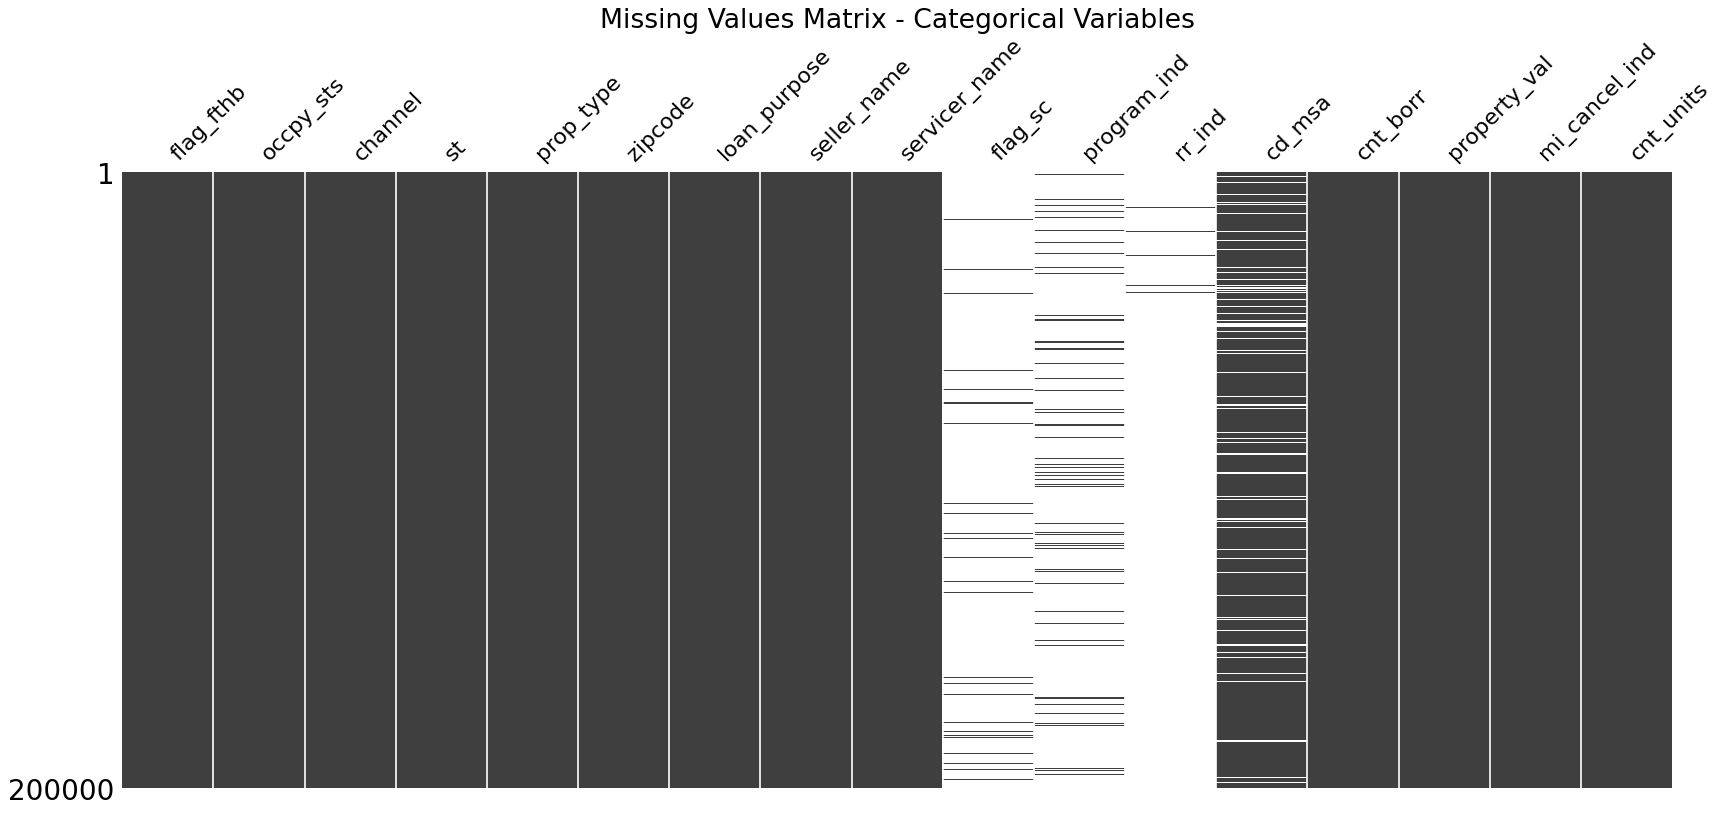

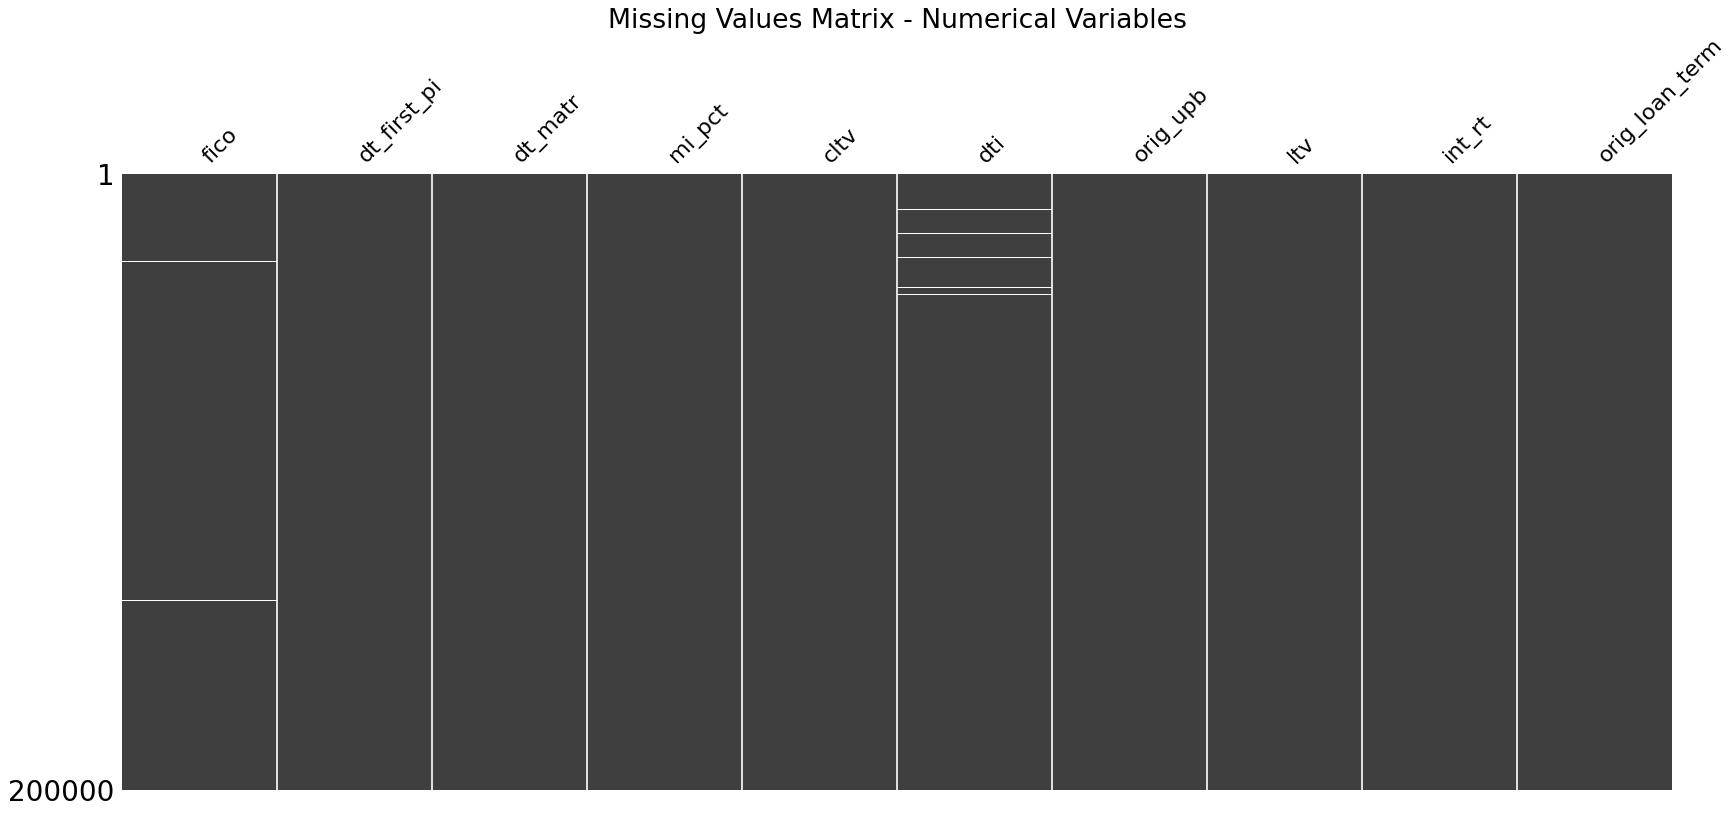

In [6]:
# 替换特定值为缺失值 NaN（根据数据字典中的定义） 方便画图
missing_value_map = {
    'fico': [9999],
    'mi_pct': [999],
    'cltv': [999],
    'dti': [999],
    'ltv': [999],
    'flag_fthb': ['9'],
    'occpy_sts': ['9'],
    'channel': ['9'],
    'prop_type': ['99'],
    'loan_purpose': ['9'],
    'program_ind': ['9'],
    'rr_ind': ['9'],
    'cnt_borr': ['9'],
    'property_val': ['9'],
    'mi_cancel_ind': ['9'],
    'cnt_units': ['99']
}

# 替换操作
for col, missing_vals in missing_value_map.items():
    d[col] = d[col].replace(missing_vals, np.nan)

# 画类别变量的缺失图
msno.matrix(d[categorical_columns], fontsize=20, sparkline=False)
plt.title("Missing Values Matrix - Categorical Variables", fontsize = 24)
plt.show()

# 画数值变量的缺失图
msno.matrix(d[numerical_columns], fontsize=20, sparkline=False)
plt.title("Missing Values Matrix - Numerical Variables", fontsize = 24)
plt.show()


通过分析我们发现大部分数据没有空值不需要填充，但是还是存在一些有空值的现象需要填充数据。
在这里我们填充数据的逻辑是：
1. 空值过多，直接删去这1列
2. 空值不多，分布呈现正态分布，我们对所有空值取mean
3. 空值不多，分布呈现偏态，我们对所有空值取median
4. 对于类别变量，对于有些列，我们直接取median（即最多的列）
5. 对于部分有特殊含义的类别变量，我们添加一个类别专门用来表示missing

具体填补操作
1. fico 呈现偏态分布，使用median填补空值
2. cd_msa 空值可能是非大都市区域，我们给空值添加一个missing类别
3. mi_pct 只有一个空，直接删去
4. cltv 只有6个空，直接删去
5. dti 偏态，median 填充
6. ltv 只有两个空，直接删去
7. flag_sc 空值的意义是否，添加新类别 将空值的类别设置为否
8. id_loan_rr 后面不用，不管
9. program_ind 空值可能有意义，加为新的missing类别
10. rr_ind 空值的意义是否，添加新类别 将空值的类别设置为否

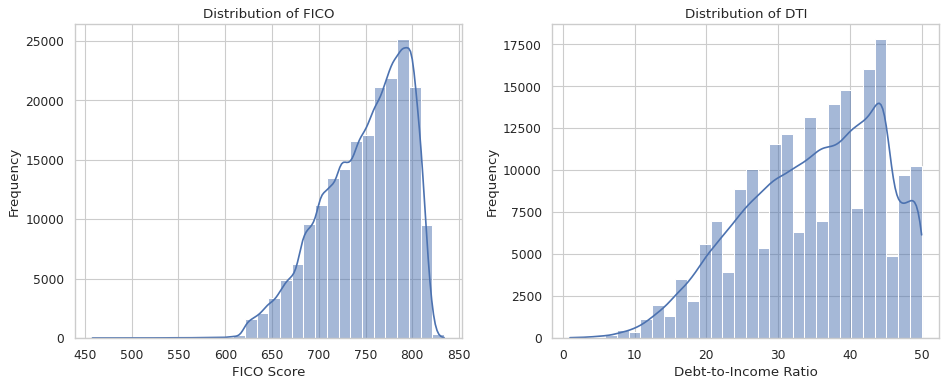

In [ ]:
# 创建一个并排的图像画布，调整画布尺寸填满空间
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 更宽的画布

# FICO 分布图（排除 9999）
sns.histplot(d[d['fico'] != 9999]['fico'], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution of FICO")
axes[0].set_xlabel("FICO Score")
axes[0].set_ylabel("Frequency")

# DTI 分布图（排除 999）
sns.histplot(d[d['dti'] != 999]['dti'], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Distribution of DTI")
axes[1].set_xlabel("Debt-to-Income Ratio")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [7]:
# 填补空值
# 1. fico：中位数填补（偏态分布）
d['fico'] = d['fico'].fillna(d['fico'].median())

# 2. cd_msa：新增一个类别 "missing"
d['cd_msa'] = d['cd_msa'].fillna('missing')

# 3. mi_pct：删除空值所在行
d = d[d['mi_pct'].notna()]

# 4. cltv：删除空值所在行
d = d[d['cltv'].notna()]

# 5. dti：中位数填补（偏态分布）
d['dti'] = d['dti'].fillna(d['dti'].median())

# 6. ltv：删除空值所在行
d = d[d['ltv'].notna()]

# 7. flag_sc：空值设为 'N'（表示否）
d['flag_sc'] = d['flag_sc'].fillna('N')

# 9. program_ind：空值设为新类别 'missing'
d['program_ind'] = d['program_ind'].fillna('missing')

# 10. rr_ind：空值设为 'N'（表示否）
d['rr_ind'] = d['rr_ind'].fillna('N')

data_labeled = d[d['loan_status'].isin(['default', 'prepaid'])]

data_labeled['target'] = (data_labeled['loan_status'] == 'default').astype(int)

# 3. 定义用于建模的特征变量（你之前分好的数值 + 类别变量）
feature_columns = categorical_columns + numerical_columns

# 4. 构建特征 X 与标签 y
X = data_labeled[feature_columns]
y = data_labeled['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



/tmp/ipykernel_1619/3650212255.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_labeled['target'] = (data_labeled['loan_status'] == 'default').astype(int)


In [8]:
# Re-import necessary libraries after code execution state reset
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import sklearn

# 示例：你之前分类的变量
categorical_columns = [
    'flag_fthb', 'occpy_sts', 'channel', 'st', 'prop_type', 'zipcode', 'loan_purpose',
    'seller_name', 'servicer_name', 'flag_sc', 'cd_msa', 'program_ind', 'rr_ind',
    'mi_cancel_ind', 'cnt_borr', 'cnt_units'
]

numerical_columns = [
    'fico', 'dt_first_pi', 'dt_matr', 'dti', 'orig_upb', 'int_rt', 'orig_loan_term'
]

# 特殊处理列（直接删除缺失值的列）
drop_na_columns = ['mi_pct', 'cltv', 'ltv']

# 数值变量用中位数填补
num_imputer = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

# 构建类别变量填补 + OneHot 编码 pipeline
cat_imputer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # 默认众数填补，后续单列特例处理
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# 构建 ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_imputer, numerical_columns),
    ('cat', cat_imputer, categorical_columns)
])

preprocessor, sklearn.__version__

(ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='median'))]),
                                  ['fico', 'dt_first_pi', 'dt_matr', 'dti',
                                   'orig_upb', 'int_rt', 'orig_loan_term']),
                                 ('cat',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('onehot',
                                                   OneHotEncoder(drop='first',
                                                                 handle_unknown='ignore'))]),
                                  ['flag_fthb', 'occpy_sts', 'channel', 'st',
                                   'prop_type', 'zipcode', 'loan_purpose',
                                   'seller_name', 'servicer_name', 'flag_

# Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft and the appropriate type of plot and summary for each variable type - your report should include figures but they should be as focused and impactful as possible.*

*You should also split your data into training and testing sets, ideally before you look to much into the features and relationships with the target*

*Additionally, this section should also motivate and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. Pipelines should be used and feature engineering steps that are be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

# Model Fitting and Tuning

*In this section you should detail and motivate your choice of model and describe the process used to refine, tune, and fit that model. You are encouraged to explore different models but you should NOT include a detailed narrative or code of all of these attempts. At most this section should briefly mention the methods explored and why they were rejected - most of your effort should go into describing the final model you are using and your process for tuning and validating it.*

*This section should include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide a comparison of your model with a baseline model of your choice on the test data but only briefly describe the baseline model considered.*

# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, estimated parameters and relationships, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a banking official, who is understands the issues associated with mortgage defaults but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also discuss potential limitations or directions of future improvement of your model.*

*Finally, you should include recommendations on factors that may increase the risk of default, which may be useful for the companies to improve their understanding of
mortgage defaults, and also to explain their decisions to clients and regulatory bodies. You should also use your model to inform the company of any active loans that are at risk of default.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# Generative AI statement

*Include a statement on how generative AI was used in the project and report.*

# References

*Include references if any*

In [56]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb

[NbConvertApp] Converting notebook project2.ipynb to pdf
[NbConvertApp] ERROR | Error while converting 'project2.ipynb'
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/nbconvertapp.py", line 487, in export_single_notebook
    output, resources = self.exporter.from_filename(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/exporters/templateexporter.py", line 390, in from_filename
    return super().from_filename(filename, resources, **kw)  # type:ignore[return-value]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/exporters/exporter.py", line 201, in from_filename
    return self.from_file(f, resources=resources, **kw)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/exporters/templateexporter.py", li